In [1]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from ruamel.yaml.scalarfloat import ScalarFloat

In [2]:
# creating paths
path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-11-30' # 2
config_name = 'config_001_hollowXtCos14Prob.yaml' # 'config_001_ebert10M.yaml'
model_name = 'model_53999.pt' #  'model_24999.pt'

#config_name = 'config_001_r07.yaml' 
#model_name = 'model_84999_hollowr07.pt' 
config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)

In [11]:
# creating models
cfg = bookkeeping.load_config(config_path)
cfg.sampler.name = 'CRMTauL' #ExactSampling' # ElboLBJF CRMTauL CRMLBJF
cfg.logit_type = 'reverse_prob'
cfg.sampler.num_corrector_steps = 0
cfg.sampler.corrector_entry_time = ScalarFloat(0.0)
cfg.sampler.num_steps = 1000
cfg.sampler.is_ordinal = True

#print(cfg)
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))

#modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
#model.load_state_dict(modified_model_state)
#optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
optimizer = torch.optim.Adam(model.parameters(), cfg.optimizer.lr)

sampler = sampling_utils.get_sampler(cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}
state = bookkeeping.load_state(state, checkpoint_path)
state['model'].eval()

number of parameters:  13923971
ema state dict function


In [12]:
n_samples = 49
samples, changes = sampler.sample(model, n_samples)
saved_samples = samples

1000it [01:19, 12.57it/s]


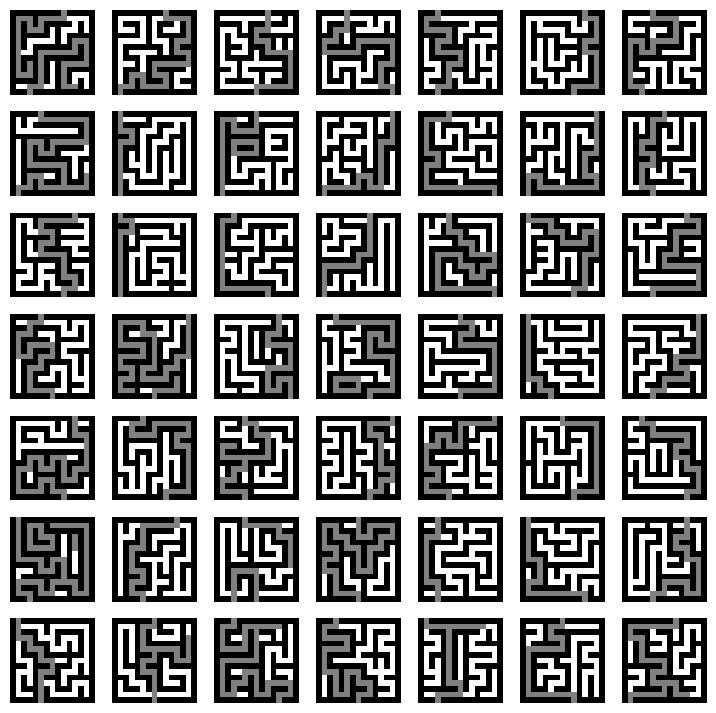

In [13]:
is_img = cfg.data.is_img

if is_img:
    samples = samples.reshape(n_samples, 1, cfg.data.image_size, cfg.data.image_size)
    saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    fig = plt.figure(figsize=(9, 9)) 
    for i in range(n_samples):
        plt.subplot(int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), 1 + i)
        plt.axis("off")
        plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")
 
 
    plt.savefig(saving_train_path)
    plt.show()
    plt.close()
else:
    bm, inv_bm = synthetic.get_binmap(cfg.model.concat_dim, cfg.data.binmode)
    print(inv_bm)
    samples = synthetic.bin2float(samples.astype(np.int32), inv_bm, cfg.model.concat_dim, cfg.data.int_scale)
 
    saving_plot_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    #aving_plot_path = '/Users/paulheller/PythonRepositories/Master-Thesis/ContTimeDiscreteSpace/TAUnSDDM/SavedModels/MNIST/'
    synthetic.plot_samples(samples, saving_plot_path, im_size=cfg.data.plot_size, im_fmt="png")

[0.4706575870513916, 0.06539682298898697, 0.04535147175192833, 0.038820862770080566, 0.03274376317858696, 0.026122448965907097, 0.029024943709373474, 0.023038547486066818, 0.02439909242093563, 0.021768707782030106, 0.022675735875964165, 0.01904761791229248, 0.018775509670376778, 0.016689341515302658, 0.017505668103694916, 0.01696145161986351, 0.017414964735507965, 0.01596371829509735, 0.015238095074892044, 0.014058956876397133, 0.014603174291551113, 0.01596371829509735, 0.016145125031471252, 0.01424036268144846, 0.013242630288004875, 0.011519273743033409, 0.011972788721323013, 0.013151926919817924, 0.012698412872850895, 0.012698412872850895, 0.01224489789456129, 0.011247165501117706, 0.012063492089509964, 0.009705215692520142, 0.010612244717776775, 0.010340135544538498, 0.011972788721323013, 0.009795918129384518, 0.012517006136476994, 0.010158729739487171, 0.01224489789456129, 0.009251700714230537, 0.009886621497571468, 0.010340135544538498, 0.009795918129384518, 0.010884353891015053, 

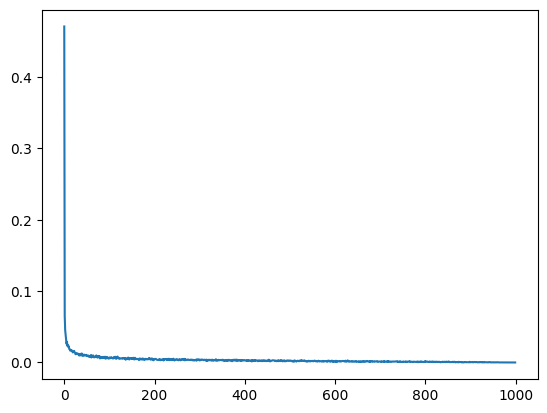

In [14]:
plt.plot(changes)
print(changes)
plt.show()